In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import json
import seaborn as sns

In [2]:
df = pd.read_parquet("hf://datasets/Vikhrmodels/mmlupro-ru/data/train-00000-of-00001.parquet")

/opt/miniconda3/envs/olga_scipts_experiment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_df, temp_df = train_test_split(
    df, 
    test_size=0.35, 
    stratify=df['category'], 
    random_state=666
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.58, 
    stratify=temp_df['category'], 
    random_state=666
)

In [4]:
train_df.category.value_counts()

category
math                147
physics             137
law                 115
chemistry           112
other               110
business            103
engineering          96
psychology           92
health               83
economics            81
biology              65
philosophy           55
history              45
computer science     31
Name: count, dtype: int64

In [5]:
val_df.category.value_counts()

category
math                33
physics             31
chemistry           26
law                 26
other               25
business            23
engineering         22
psychology          21
health              19
economics           18
biology             15
philosophy          12
history             10
computer science     7
Name: count, dtype: int64

In [6]:
test_df.category.value_counts()

category
math                46
physics             43
law                 36
chemistry           35
other               35
business            33
engineering         30
psychology          29
health              26
economics           25
biology             20
philosophy          17
history             14
computer science     9
Name: count, dtype: int64

In [7]:
def plot_zipfs_law(dfs, dataset_names):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))

    palette = sns.color_palette("husl", len(dfs))  # Use husl palette

    for df, name, color in zip(dfs, dataset_names, palette):
        text = ' '.join(df['question'].tolist())
        
        word_counts = Counter(text.split())
        word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
        
        ranks = np.arange(1, len(word_counts) + 1)
        frequencies = list(word_counts.values())
        
        plt.loglog(ranks, frequencies, marker=".", label=name, color=color)

    plt.title("Zipf's Plots", fontsize=16, fontweight='bold')
    plt.xlabel('Rank', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.legend(title='Dataset', title_fontsize='13', fontsize='11')
    plt.tight_layout()

The closeness of the three lines suggests that the datasets are well balanced in terms of linguistic content.

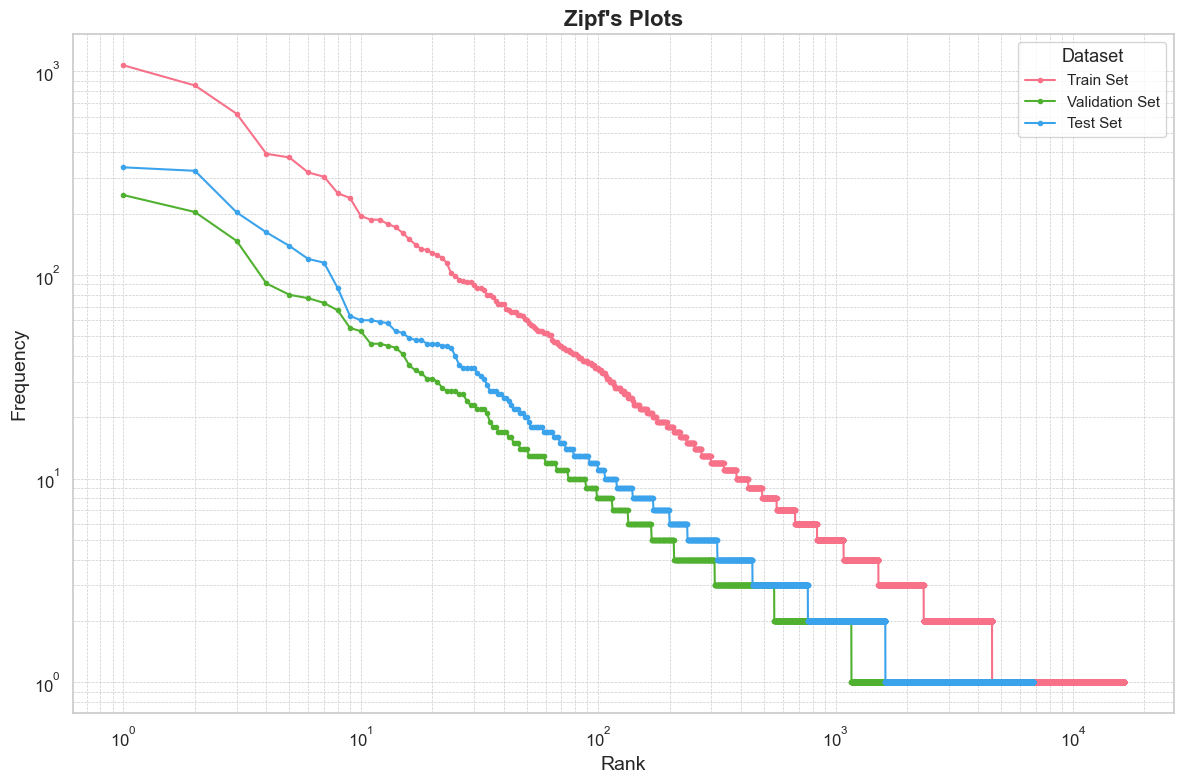

In [8]:
plot_zipfs_law([train_df, val_df, test_df], ['Train Set', 'Validation Set', 'Test Set'])
plt.show()

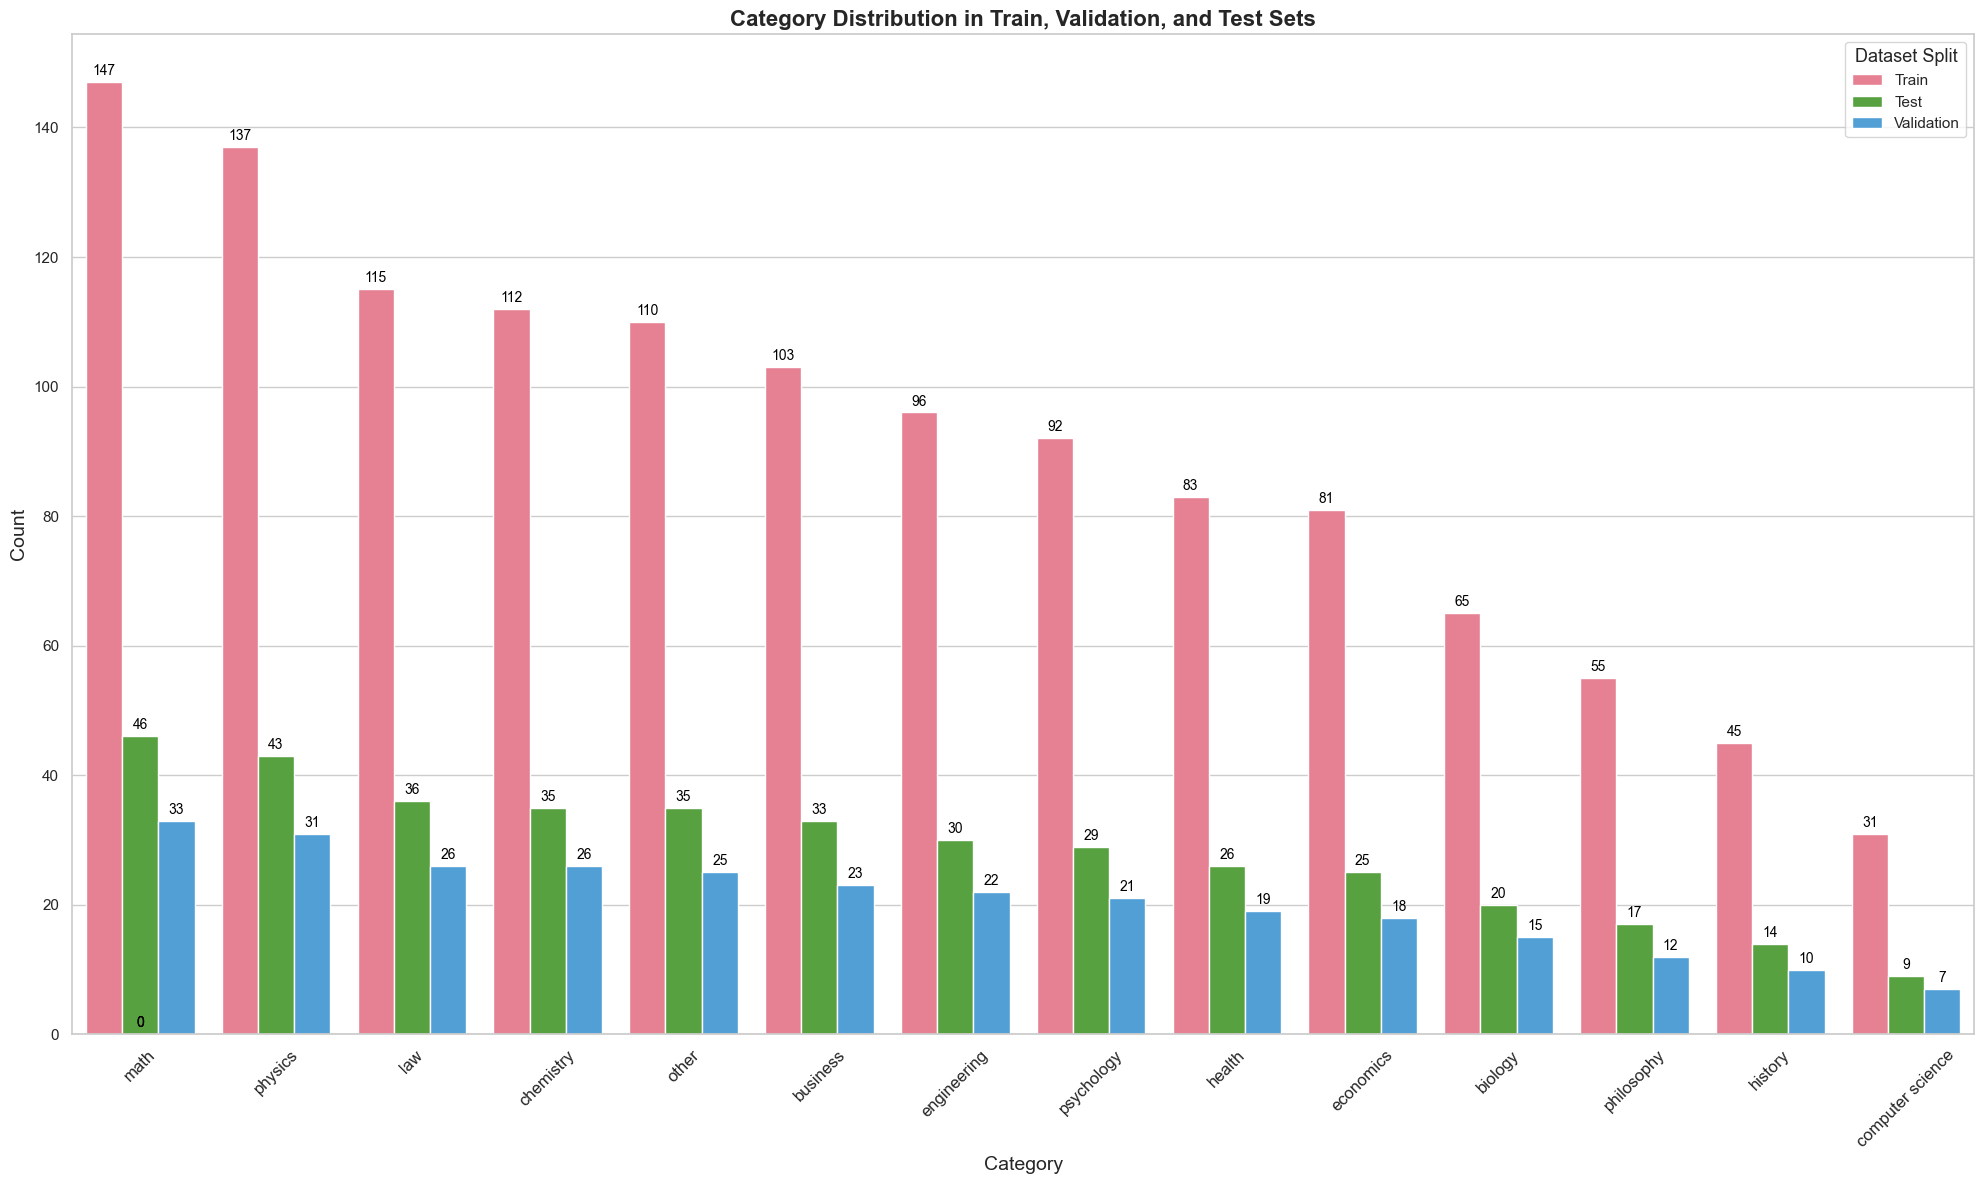

In [9]:
def prepare_category_distribution(df, split_name):
    category_counts = df['category'].value_counts().reset_index()
    category_counts.columns = ['category', 'count']
    category_counts['split'] = split_name
    return category_counts

train_dist = prepare_category_distribution(train_df, 'Train')
val_dist = prepare_category_distribution(val_df, 'Validation')
test_dist = prepare_category_distribution(test_df, 'Test')

combined_dist = pd.concat([train_dist, test_dist, val_dist])

sns.set_theme(style="whitegrid")

palette = sns.color_palette("husl", 3)

plt.figure(figsize=(20, 12))
bar_plot = sns.barplot(x='category', y='count', hue='split', data=combined_dist, palette=palette, edgecolor='w')

for p in bar_plot.patches:
    height = p.get_height()
    bar_plot.annotate(f'{int(height)}', 
                      (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                      textcoords='offset points')

plt.title('Category Distribution in Train, Validation, and Test Sets', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.legend(title='Dataset Split', title_fontsize='13', fontsize='11', loc='upper right')
plt.tight_layout()
plt.show()

In [10]:
splits = {
    'train': train_df['question_id'].tolist(),
    'validation': val_df['question_id'].tolist(),
    'test': test_df['question_id'].tolist()
}

with open('../data/dataset_splits.json', 'w') as file:
    json.dump(splits, file)

train_df.to_csv('../data/train_df.csv', index=False)
val_df.to_csv('../data/val_df.csv', index=False)
test_df.to_csv('../data/test_df.csv', index=False)